# LeCun's LeNet and Improved Architectures on Fashion-MNIST

This notebook builds upon the MLP implementation to implement more advanced architectures, starting with LeNet and progressing to transfer learning with pre-trained models.

## Key Steps:
    1. Implement LeNet, LeNet-5, a classic CNN architecture.
    2. Train and evaluate LeNet on Fashion-MNIST.
    3. Explore improvements to LeNet through architectural modifications.
    3.1 Observations: Performance, Overfitting, ETC
    4. Building our own CNN model from scratch with explained model improvements
    5. Use transfer learning with pre-trained models to achieve better performance.

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import torch.optim as optim

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

I have a local GPU, so I'll use that.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

device = torch.device(device)

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) 

        # Compute prediction error
        pred = model(X)                     
        loss = loss_fn(pred, y)             

        # This is the backprop set up. 
        loss.backward()                     
        optimizer.step()                    
        optimizer.zero_grad()               

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



1. model.train(): This sets the model to training mode. By calling model.train(), we are indicating that the model should update its parameters based on the current training batch.

2. X, y = X.to(device), y.to(device): This moves the input data (X and y) to the specified device (e.g., GPU) if available. This is done to ensure that the model and data are on the same device, facilitating faster computations.

3. pred = model(X): This is the forward pass through the neural network. It computes the predicted output (pred) based on the input data (X) using the current model.

4. loss = loss_fn(pred, y): This calculates the loss between the predicted output (pred) and the actual target values (y). The loss function (loss_fn) quantifies how well the model is performing. The goal during training is to minimize this loss.

5. loss.backward(): This is part of the backpropagation process. It calculates the gradients of the model parameters with respect to the loss. These gradients represent how much the model's parameters should be adjusted to minimize the loss.

6. optimizer.step(): This updates the model parameters based on the computed gradients. The optimizer is responsible for adjusting the model's weights to minimize the loss. The choice of optimizer (e.g., SGD, Adam) and its hyperparameters is specified when creating the optimizer.

7. optimizer.zero_grad(): This is used to zero out the gradients calculated in the backward() step. Gradients are accumulated by default in PyTorch, and calling zero_grad() ensures that the gradients from the previous batch do not affect the current batch. If this step is omitted, the gradients will be accumulated across batches, leading to incorrect parameter updates.

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these.
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

100%|██████████| 26421880/26421880 [00:02<00:00, 12171264.62it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199702.34it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3571738.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23192563.90it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



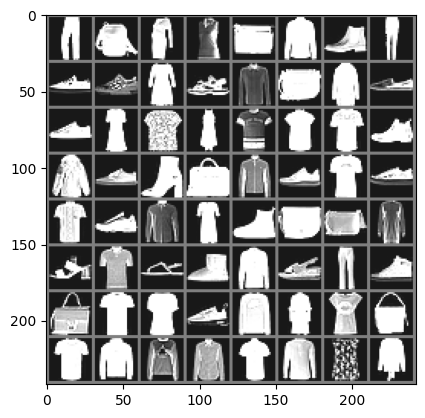

In [4]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))
])

# Load Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers =2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


---
## 1. Replicate the Neural Network from the MLP_from_scratch for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100) # Fully connected layer 1 with 784 input features and 100 output features
        self.fc2 = nn.Linear(100, 100) # Fully connected layer 2 with 100 input features and 100 output features
        self.fc3 = nn.Linear(100, 50) # Fully connected layer 2 with 100 input features and 50 output features
        self.output_layer = nn.Linear(50, 10) # Output layer with 50 input features and 10 output features (i.e. classess)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input tensor to have a shape of (batch_size, 784)
        x = torch.relu(self.fc1(x)) # Apply ReLU activation to the output of the first fully connected layer
        x = torch.relu(self.fc2(x)) # Apply ReLU activation to the output of the second fully connected layer
        x = torch.relu(self.fc3(x)) # Apply ReLU activation to the output of the third fully connected layer
        x = self.output_layer(x)
        return x

# Create an instance of the model and move it to the appropriate device
model = NeuralNetwork().to(device)

# Display a summary of the model, showing layer-wise information and the total number of parameters
summary(model, (1, 28 * 28))

# Test the model with random inputs on the same device
random_input = torch.randn(1, 1, 28, 28).to(device)
output = model(random_input)
print("Model Output Shape:", output.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                  [-1, 100]          10,100
            Linear-3                   [-1, 50]           5,050
            Linear-4                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.36
Estimated Total Size (MB): 0.36
----------------------------------------------------------------
Model Output Shape: torch.Size([1, 10])


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

In [ ]:
# Define the loss function (CrossEntropyLoss) and the optimizer (Adam)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#train the model using the train_loop function provided
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader , model , loss_fn, optimizer, epochs = 20)

Epoch 1:

loss: 2.312695  [   64/60000]
loss: 0.546592  [ 6464/60000]
loss: 0.474383  [12864/60000]
loss: 0.334312  [19264/60000]
loss: 0.551421  [25664/60000]
loss: 0.379327  [32064/60000]
loss: 0.307592  [38464/60000]
loss: 0.458990  [44864/60000]
loss: 0.383879  [51264/60000]
loss: 0.411979  [57664/60000]
Train Error: 
 Accuracy: 86.6%, Avg loss: 0.365249 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.407968 

Epoch 2:

loss: 0.526385  [   64/60000]
loss: 0.373711  [ 6464/60000]
loss: 0.389959  [12864/60000]
loss: 0.345154  [19264/60000]
loss: 0.310805  [25664/60000]
loss: 0.384063  [32064/60000]
loss: 0.430003  [38464/60000]
loss: 0.506794  [44864/60000]
loss: 0.308956  [51264/60000]
loss: 0.383143  [57664/60000]
Train Error: 
 Accuracy: 86.9%, Avg loss: 0.353628 

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.407995 

Epoch 3:

loss: 0.493738  [   64/60000]
loss: 0.281436  [ 6464/60000]
loss: 0.391116  [12864/60000]
loss: 0.478226  [19264/60000]
loss: 0.368048  [25664/60000]
loss: 0.24

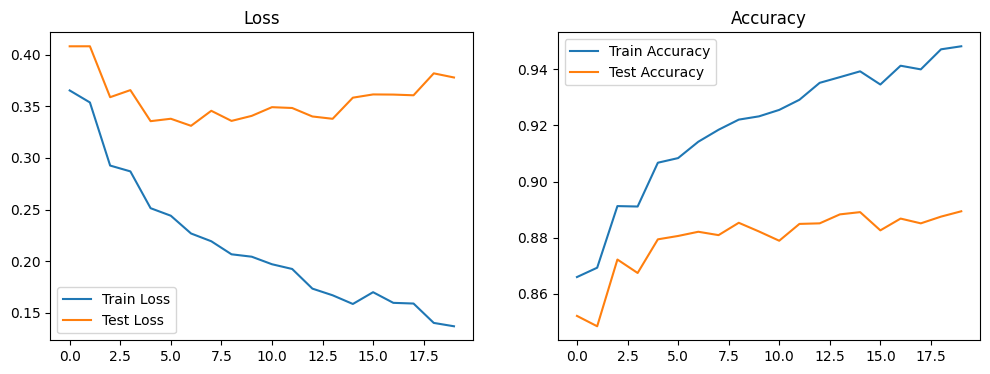

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


1. **Loss Graph (left subplot):**
   - Both training and testing loss decrease over epochs, indicating that the model is learning from the data. However, the train loss after deceasing starts to increase show bad generalization to unseen data i.e. Overfitting.
   - The gap between training and testing loss is relatively small, suggesting that the model is not overfitting much the training data and generalizing okayish to unseen data. Even though the graph looks like the gap is massive but lookung at the y axis, it's approx 0.3 difference between the losses at 20th epoch but it's still overfitting to some degree.
   - There's a slight increase in testing loss towards the later epochs, which indicates that the model is starting to overfit.

2. **Accuracy Graph (right subplot):**
   - Both training and testing accuracy increase over epochs, which is a positive sign of the model learning the underlying patterns in the data.
   - The training accuracy is consistently higher than the testing accuracy, which is expected. However, the relatively small gap suggests good generalization, but then again the increasing gap suggests that it's overfitting with increasing epochs.

3. **Overall:**
   - The model seems to be learning effectively, achieving high accuracy on the training and and relatively good accuracy on testing sets.

4. **Observations:**
   - The model's performance on the testing set is consistent and comparable to the training set, indicating good generalization.
   - There is a slight increase in testing loss towards the end of the training, which indicate overfitting.



---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

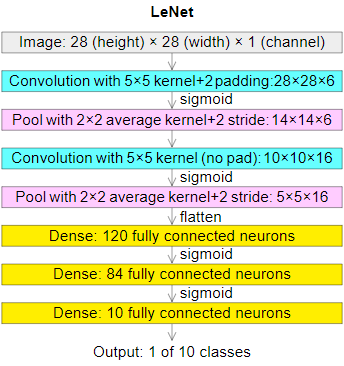

### Replication from LeCuns original lenet paper:

Here's the paragraph from his paper where he explain the architecture of this model.

> One of the best networks we found for both online and
offline character recognition is a five-layer convolutional
network somewhat similar to LeNet-5 (Fig. 2), but with
multiple input planes and different numbers of units on
the last two layers—layer one: convolution with eight
kernels of size 3 3; layer two: 2 2 subsampling; layer
three: convolution with 25 kernels of size 5 5; layer
four: convolution with 84 kernels of size 4 4; layer five:
2 1 subsampling; classification layer: 95 RBF units (one
per class in the full printable ASCII set). The distributed
codes on the output are the same as for LeNet-5, except
they are adaptive unlike with LeNet-5.

I have replicated the same model

In [2]:
# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 25, kernel_size=5)
        self.conv3 = nn.Conv2d(25, 84, kernel_size=4)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(84 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        x = self.pool2(x)
        x = x.view(-1, 84 * 4 * 4)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Create LeNet-5 model
lenet_model = LeNet5().to(device)

# Display LeNet-5 model summary
summary(lenet_model, (1, 32, 32))

# Define loss function and optimizer
lenet_loss_fn = nn.CrossEntropyLoss()
lenet_optimizer = optim.Adam(lenet_model.parameters(), lr=1e-3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 25, 12, 12]           5,025
            Conv2d-4             [-1, 84, 9, 9]          33,684
         MaxPool2d-5             [-1, 84, 4, 4]               0
            Linear-6                  [-1, 120]         161,400
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 211,203
Trainable params: 211,203
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.81
Estimated Total Size (MB): 0.98
----------------------------------------------------------------


In [5]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((32, 32)), #as lenet was created for 32 x 32 image features
    transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))
])

# Load Fashion-MNIST dataset
train_dataset_lenet = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_lenet = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader_lenet = DataLoader(train_dataset_lenet, batch_size=batch_size, shuffle=True, num_workers =2)
test_loader_lenet = DataLoader(test_dataset_lenet, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Training LeNet-5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader_lenet, test_loader_lenet, lenet_model, lenet_loss_fn, lenet_optimizer, 20)

Epoch 1:

loss: 2.325654  [   64/60000]
loss: 0.688083  [ 6464/60000]
loss: 0.433543  [12864/60000]
loss: 0.519238  [19264/60000]
loss: 0.335469  [25664/60000]
loss: 0.549074  [32064/60000]
loss: 0.405235  [38464/60000]
loss: 0.341000  [44864/60000]
loss: 0.450543  [51264/60000]
loss: 0.457437  [57664/60000]
Train Error: 
 Accuracy: 85.0%, Avg loss: 0.412892 

Test Error: 
 Accuracy: 83.7%, Avg loss: 0.448810 

Epoch 2:

loss: 0.468040  [   64/60000]
loss: 0.274249  [ 6464/60000]
loss: 0.269296  [12864/60000]
loss: 0.407906  [19264/60000]
loss: 0.301591  [25664/60000]
loss: 0.552792  [32064/60000]
loss: 0.197478  [38464/60000]
loss: 0.319695  [44864/60000]
loss: 0.359812  [51264/60000]
loss: 0.256919  [57664/60000]
Train Error: 
 Accuracy: 86.4%, Avg loss: 0.355544 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.397628 

Epoch 3:

loss: 0.277525  [   64/60000]
loss: 0.516245  [ 6464/60000]
loss: 0.363785  [12864/60000]
loss: 0.271394  [19264/60000]
loss: 0.350602  [25664/60000]
loss: 0.32

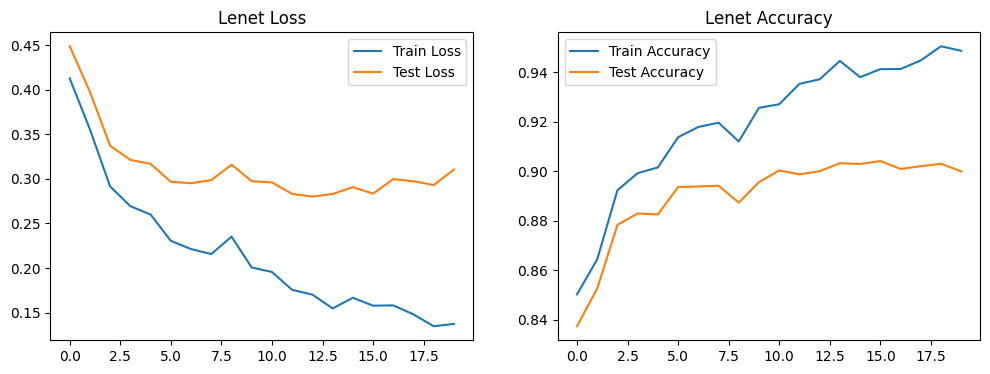

In [ ]:
# Plotting loss and accuracy of the model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.title('Lenet Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()
plt.title('Lenet Accuracy')

plt.show()


### LeNet-5 Model vs Fully Connected Model
Number of Parameters:
1. LeNet-5 Model:
Total params: 211,203
Trainable params: 211,203

2. Fully Connected Model:
Total params: 94,160
Trainable params: 94,160

Now, considering the number of parameters for the fully connected model, it has significantly fewer parameters compared to the LeNet-5 model. The fully connected model is simpler in terms of parameter count.

Performance:

1. LeNet-5 Model: Accuracy after 20 epochs: 90.0%
2. Fully Connected Model: accuracy after 20 epochs: 89.9%

Given this, both models achieve similar accuracy on the test set after 20 epochs. The difference in performance is not substantial, and both models appear to generalize well on the dataset.

Overfitting:

Both models demonstrate good generalization as the training and test accuracies are close. Yes, the graph can look like there's a huge gap in the training and test accuracy but on a closer look the difference is not much when you check the accuracy value from the y-axis.

In summary, while the LeNet-5 model has more parameters, it achieves similar performance to the corrected fully connected model.The fully connected model, with its fewer parameters, might be more computationally efficient, but the LeNet-5 model introduces convolutional layers, which are powerful for handling spatial features in image data.


---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


> Modern CNNs often use the Rectified Linear Unit (ReLU) activation function and replace traditional pooling layers with techniques like max-pooling. Additionally, batch normalization is commonly used to improve training stability and speed.

In [6]:
class ModernLeNet5(nn.Module):
    def __init__(self):
        super(ModernLeNet5, self).__init__()

        # First convolutional layer with 8 output channels, 3x3 kernel, and padding
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)

        # Batch normalization for the output of the first convolutional layer
        self.batchnorm1 = nn.BatchNorm2d(8)

        # Max pooling layer with 2x2 kernel and stride 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Similar comments, so I'll avoid the comments to make the code clearner and less cluttered.
        self.conv2 = nn.Conv2d(8, 25, kernel_size=5)
        self.batchnorm2 = nn.BatchNorm2d(25)
        self.conv3 = nn.Conv2d(25, 84, kernel_size=4)
        self.batchnorm3 = nn.BatchNorm2d(84)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(84 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        #apply the convolution layers with batch norm and relu activation
        x = torch.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = torch.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool2(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        #finally add the fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Create mordern LeNet-5 model
mordern_lenet_model = ModernLeNet5().to(device)

# Define mordern loss function and optimizer
lenet_loss_fn = nn.CrossEntropyLoss()
modern_lenet_optimizer = optim.Adam(mordern_lenet_model.parameters(), lr=1e-3)

# Display mordern LeNet-5 model summary
summary(mordern_lenet_model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 25, 12, 12]           5,025
       BatchNorm2d-5           [-1, 25, 12, 12]              50
            Conv2d-6             [-1, 84, 9, 9]          33,684
       BatchNorm2d-7             [-1, 84, 9, 9]             168
         MaxPool2d-8             [-1, 84, 4, 4]               0
            Linear-9                  [-1, 120]         161,400
           Linear-10                   [-1, 84]          10,164
           Linear-11                   [-1, 10]             850
Total params: 211,437
Trainable params: 211,437
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [7]:
# Training Mordern LeNet-5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader_lenet, test_loader_lenet, mordern_lenet_model, lenet_loss_fn, modern_lenet_optimizer, 20)

Epoch 1:

loss: 2.312391  [   64/60000]
loss: 0.471742  [ 6464/60000]
loss: 0.301527  [12864/60000]
loss: 0.388552  [19264/60000]
loss: 0.325362  [25664/60000]
loss: 0.170097  [32064/60000]
loss: 0.323613  [38464/60000]
loss: 0.306551  [44864/60000]
loss: 0.271705  [51264/60000]
loss: 0.358464  [57664/60000]
Train Error: 
 Accuracy: 89.5%, Avg loss: 0.291971 

Test Error: 
 Accuracy: 87.9%, Avg loss: 0.332646 

Epoch 2:

loss: 0.176668  [   64/60000]
loss: 0.231810  [ 6464/60000]
loss: 0.232867  [12864/60000]
loss: 0.226072  [19264/60000]
loss: 0.136145  [25664/60000]
loss: 0.207808  [32064/60000]
loss: 0.194524  [38464/60000]
loss: 0.174096  [44864/60000]
loss: 0.297330  [51264/60000]
loss: 0.288270  [57664/60000]
Train Error: 
 Accuracy: 90.5%, Avg loss: 0.247075 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.319358 

Epoch 3:

loss: 0.246320  [   64/60000]
loss: 0.295870  [ 6464/60000]
loss: 0.181895  [12864/60000]
loss: 0.309875  [19264/60000]
loss: 0.237747  [25664/60000]
loss: 0.19

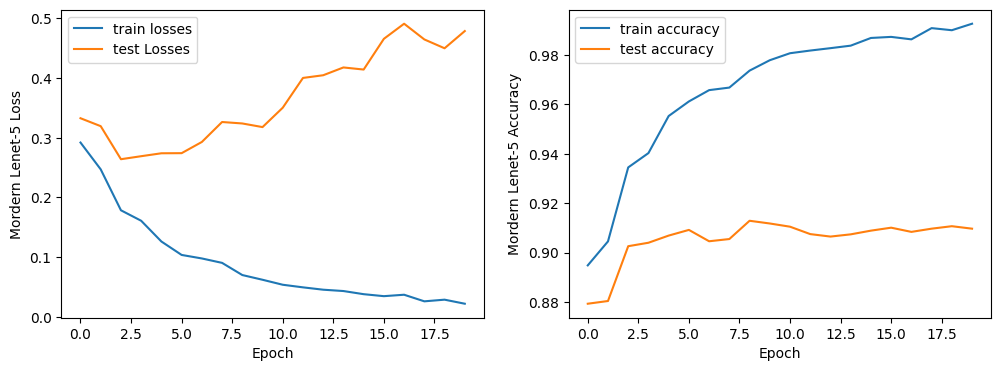

In [9]:
# Plotting loss and accuracy of the model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train losses')
plt.plot(test_loss, label='test Losses')
plt.xlabel('Epoch')
plt.ylabel('Mordern Lenet-5 Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mordern Lenet-5 Accuracy')
plt.legend()

plt.show()


# Observations and Comparisons:

The **ModernLeNet5** model is an enhanced version of the LeNet-5 model, incorporating convolutional layers with batch normalization and ReLU activations.

- **LeNet-5:**
  - Traditional convolutional layers, fully connected layers, and pooling layers.

- **ModernLeNet5:**
  - Batch normalization after each convolutional layer.
  - Uses ReLU activations.

## Number of Parameters:

- **LeNet-5:**
  - Total parameters: 211,203.

- **Fully Connected Model:**
  - Parameters: 94,160.

- **ModernLeNet5:**
  - Parameters: 211,437

## Performance:

- Both LeNet-5 and the fully connected model achieved similar accuracy around 90% after 20 epochs. But the train accuracy is >99% in the MordernLenet

- **ModernLeNet5:**
  - Reaches an accuracy of 91.0% after 20 epochs for test data.

## Overfitting:

- Both LeNet-5 and the fully connected model show good generalization, with small differences between training and test accuracies.

- **ModernLeNet5:**
  - Demonstrates a similar trend but the overfitting is much more higher with increasing epochs. I'll add a dropout in the "build your own cnn" part to reduce this overfitting trend.

## Training Progress:

- **ModernLeNet5:**
  - Shows a consistent improvement in accuracy and loss over epochs.
  - Achieves a higher accuracy than both LeNet-5 and the fully connected model.

## Convergence Speed:

- **ModernLeNet5:**
  - Converges faster than LeNet-5 and the fully connected model, achieving higher accuracy in earlier epochs.

## Observations:

- The addition of batch normalization and ReLU activations in ModernLeNet5 helps in faster convergence and but potentially worse generalization due to big difference in training and test accuracies (Esp in later stages/epochs).

- The increased depth of ModernLeNet5 may allow it to capture more complex features in the data, leading to improved performance.

- The higher accuracy of ModernLeNet5 suggests that the introduction of modern techniques in CNNs can contribute to better model performance.


---
# 4. Build your own CNN model
---

Build your own classifier model 

Notes:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters

In [7]:
import torch.optim as optim

# Improved CNN model with dropout in fully connected layers
class ImprovedClassifier(nn.Module):
    def __init__(self):
        super(ImprovedClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.batchNormal1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchNormal2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchNormal3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.batchNormal4 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 10)
        self.dropout2 = nn.Dropout(0.5)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batchNormal1(self.conv1(x)))
        x = self.relu(self.batchNormal2(self.conv2(x)))
        x = self.pool1(x)
        x = self.relu(self.batchNormal3(self.conv3(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.batchNormal4(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        return x

# Instantiate the model and send it to the GPU if available
ImprovedClassifier_model = ImprovedClassifier().to(device)

# Display model summary
summary(ImprovedClassifier_model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Flatten-12                 [-1, 6272]               0
           Linear-13                  [-1, 256]       1,605,888
      BatchNorm1d-14                  [

In [8]:
# Define the loss function and the optimizer
ImprovedClassifier_loss_fn = nn.CrossEntropyLoss()
ImprovedClassifier_model_optimizer = torch.optim.Adam(ImprovedClassifier_model.parameters(), lr=1e-3)

# Train the CNN model
ImprovedClassifier_train_loss, ImprovedClassifier_train_accuracy, ImprovedClassifier_test_loss, ImprovedClassifier_test_accuracy = train_loop(train_loader, test_loader, ImprovedClassifier_model,
                                                                                              ImprovedClassifier_loss_fn, ImprovedClassifier_model_optimizer, 20)

Epoch 1:

loss: 2.543340  [   64/60000]
loss: 1.502303  [ 6464/60000]
loss: 1.498383  [12864/60000]
loss: 1.406431  [19264/60000]
loss: 1.543642  [25664/60000]
loss: 1.406639  [32064/60000]
loss: 1.556423  [38464/60000]
loss: 1.307830  [44864/60000]
loss: 1.387385  [51264/60000]
loss: 1.422875  [57664/60000]
Train Error: 
 Accuracy: 90.6%, Avg loss: 0.552677 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.582310 

Epoch 2:

loss: 1.339047  [   64/60000]
loss: 1.327640  [ 6464/60000]
loss: 1.542937  [12864/60000]
loss: 1.264482  [19264/60000]
loss: 1.165360  [25664/60000]
loss: 1.096647  [32064/60000]
loss: 1.602634  [38464/60000]
loss: 1.647494  [44864/60000]
loss: 1.419398  [51264/60000]
loss: 1.230622  [57664/60000]
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.510478 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.550754 

Epoch 3:

loss: 1.174137  [   64/60000]
loss: 1.208676  [ 6464/60000]
loss: 1.283358  [12864/60000]
loss: 1.226280  [19264/60000]
loss: 1.386756  [25664/60000]
loss: 1.59

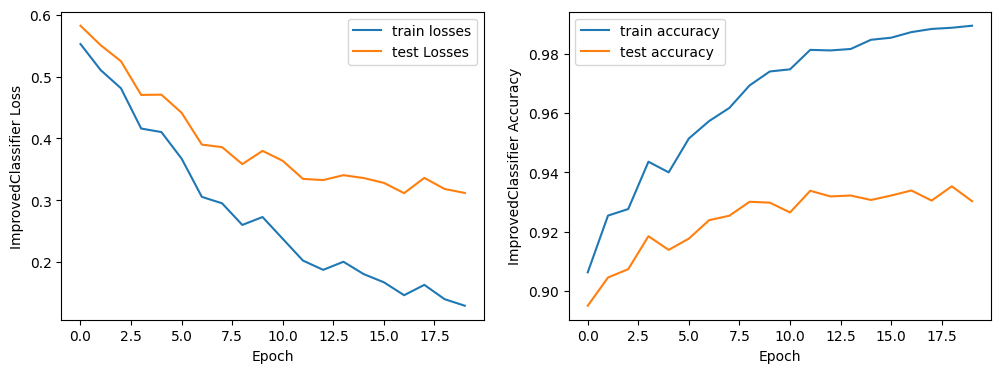

In [9]:
# Plotting loss and accuracy of the model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ImprovedClassifier_train_loss, label='train losses')
plt.plot(ImprovedClassifier_test_loss, label='test Losses')
plt.xlabel('Epoch')
plt.ylabel('ImprovedClassifier Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ImprovedClassifier_train_accuracy, label='train accuracy')
plt.plot(ImprovedClassifier_test_accuracy, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('ImprovedClassifier Accuracy')
plt.legend()

plt.show()

I'll compare the MordernLenet model and this ImprovedClassifer Model

**Similarities:**
1. **Number of Convolutional Layers:**
   - Both models have three convolutional layers, enabling them to learn hierarchical features at different levels.

2. **Batch Normalization:**
   - Both models use batch normalization after each convolutional layer, promoting stable and faster training.

3. **ReLU Activation:**
   - ReLU activation is applied after each convolutional layer in both models, introducing non-linearity.

**Differences:**
1. **Channel Configuration:**
   - In ModernLeNet5, the channel configuration is 8, 25, and 84 for the three convolutional layers.
   - In ImprovedClassifer, the channel configuration is 32, 64, and 128.

2. **Pooling Layers:**
   - ModernLeNet5 uses max-pooling layers with a 2x2 kernel and stride 2 after each convolutional block.
   - ImprovedClassifer uses max-pooling layers in a similar fashion but after the first two convolutional blocks.

3. **Fully Connected Layers:**
   - ModernLeNet5 has three fully connected layers with sizes 120, 84, and 10.
   - ImprovedClassifer has two fully connected layers with sizes 256 and 10.

4. **Batch Normalization in Fully Connected Layers:**
   - ImprovedClassifer applies batch normalization after the first fully connected layer, while ModernLeNet5 does not include batch normalization in its fully connected layers.


5. **Dropout in Fully Connected Layers:**
  - Dropout is a regularization technique that involves randomly setting a    fraction of input units to zero during each update of the model parameters. This helps prevent overfitting by introducing noise and reducing the reliance on specific neurons, forcing the network to learn more robust and generalized features.

In essence, both models follow a similar architecture with three convolutional layers, batch normalization, and ReLU activation. The differences lie in the specific channel configurations, pooling layer placements, fully connected layer sizes, and the presence of batch normalization in fully connected layers.

### Why did I implemented this changes?

## Explanation of Model Improvements

### 1. Increased Model Complexity:
   - The ImprovedClassifer model has a more complex architecture with increased numbers of channels in the convolutional layers (32, 64, 128). This increased capacity allows the model to capture more intricate patterns and features in the data, potentially enhancing its ability to discriminate between different classes.

### 2. Batch Normalization:
   - The inclusion of batch normalization after convolutional and fully connected layers helps stabilize and accelerate the training process. It normalizes the input to each layer and can lead to more efficient convergence during training.

### 3. Adjustment of Fully Connected Layer Sizes:
   - The adjustment of fully connected layer sizes (256 and 10) impact the model's representation and decision-making capabilities. Larger fully connected layers can potentially capture more complex relationships in the data, but it also increases the number of parameters.

### 4. Batch Normalization in Fully Connected Layers:
   - Applying batch normalization after the first fully connected layer helps maintain stable activations during training, potentially leading to faster convergence and better generalization.

### 5. Addition of Dropouts:
  - Dropout acts as a regularization technique, preventing overfitting by discouraging complex co-adaptations on training data. Dropout reduces the risk of overfitting to specific neurons, making the model more robust and less sensitive to noise in the training data.

## Observation:

The improved classifier demonstrates a consistent decrease in both training and test errors over the 20 epochs, showcasing its ability to learn and generalize effectively. Adding the dropout layer helped in reducing the gap between the training and test accuracy comparated to the mordern lenel classifer model.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [ ]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

100%|██████████| 26421880/26421880 [00:02<00:00, 11142337.29it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 178488.87it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3195077.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4826168.30it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Approach 1: Replace Last Fully Connected Layer with Random Weights

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Load ResNet18 with random weights
resnet18_rand = models.resnet18(pretrained=False) #default weights not used
resnet18_rand.fc = nn.Linear(resnet18_rand.fc.in_features, 10)  # Replace last layer with a new one for 10 classes
resnet18_rand.to(device)

resnet18_rand_optimizer = optim.Adam(resnet18_rand.parameters(), lr=1e-3)

train_loss_rand, train_acc_rand, test_loss_rand, test_acc_rand = train_loop(train_dataloader, test_dataloader, resnet18_rand, loss_fn, resnet18_rand_optimizer, 20)


Epoch 1:

loss: 2.548076  [   64/60000]
loss: 0.510961  [ 6464/60000]
loss: 0.361193  [12864/60000]
loss: 0.427864  [19264/60000]
loss: 0.560200  [25664/60000]
loss: 0.396881  [32064/60000]
loss: 0.297893  [38464/60000]
loss: 0.508682  [44864/60000]
loss: 0.330332  [51264/60000]
loss: 0.444904  [57664/60000]
Train Error: 
 Accuracy: 85.0%, Avg loss: 0.392326 

Test Error: 
 Accuracy: 83.4%, Avg loss: 0.434958 

Epoch 2:

loss: 0.291964  [   64/60000]
loss: 0.332232  [ 6464/60000]
loss: 0.307769  [12864/60000]
loss: 0.276513  [19264/60000]
loss: 0.305792  [25664/60000]
loss: 0.408371  [32064/60000]
loss: 0.238601  [38464/60000]
loss: 0.393350  [44864/60000]
loss: 0.267195  [51264/60000]
loss: 0.307458  [57664/60000]
Train Error: 
 Accuracy: 86.8%, Avg loss: 0.333190 

Test Error: 
 Accuracy: 84.9%, Avg loss: 0.385521 

Epoch 3:

loss: 0.216555  [   64/60000]
loss: 0.288834  [ 6464/60000]
loss: 0.244566  [12864/60000]
loss: 0.260414  [19264/60000]
loss: 0.336467  [25664/60000]
loss: 0.36

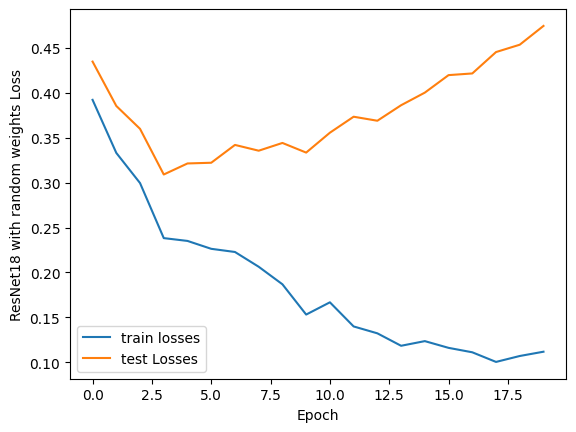

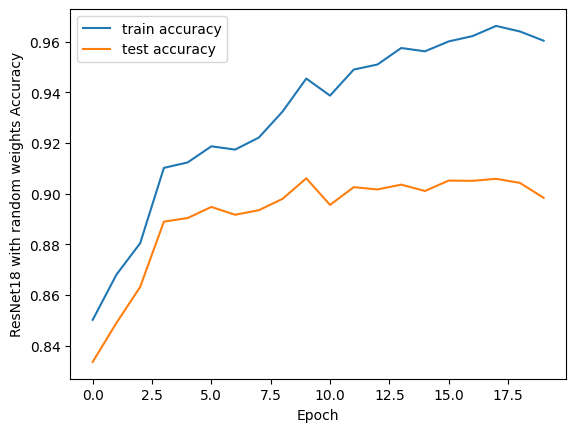

In [ ]:
# Plotting the training losses and accuracies for comparison
plt.plot(train_loss_rand, label='train losses')
plt.plot(test_loss_rand, label='test Losses')
plt.xlabel('Epoch')
plt.ylabel('ResNet18 with random weights Loss')
plt.legend()
plt.show()

plt.plot(train_acc_rand, label='train accuracy')
plt.plot(test_acc_rand, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('ResNet18 with random weights Accuracy')
plt.legend()
plt.show()

Approach 2: Replace Last Fully Connected Layer with Default Parameters

In [ ]:
# Load ResNet18 with default weights
resnet18_default = models.resnet18(pretrained=True) #default weights used
resnet18_default.fc = nn.Linear(resnet18_default.fc.in_features, 10)  # Replace last layer with a new one for 10 classes
resnet18_default.to(device)

resnet18_default_optimizer = optim.Adam(resnet18_default.parameters(), lr=1e-3)

train_loss_default, train_acc_default, test_loss_default, test_acc_default = train_loop(train_dataloader, test_dataloader, resnet18_default, loss_fn, resnet18_default_optimizer, 20)

Epoch 1:

loss: 2.372691  [   64/60000]
loss: 0.415024  [ 6464/60000]
loss: 0.360096  [12864/60000]
loss: 0.424384  [19264/60000]
loss: 0.415536  [25664/60000]
loss: 0.357632  [32064/60000]
loss: 0.232310  [38464/60000]
loss: 0.396769  [44864/60000]
loss: 0.285865  [51264/60000]
loss: 0.276477  [57664/60000]
Train Error: 
 Accuracy: 87.3%, Avg loss: 0.342128 

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.381396 

Epoch 2:

loss: 0.294475  [   64/60000]
loss: 0.323500  [ 6464/60000]
loss: 0.193451  [12864/60000]
loss: 0.293553  [19264/60000]
loss: 0.363895  [25664/60000]
loss: 0.370492  [32064/60000]
loss: 0.302539  [38464/60000]
loss: 0.332083  [44864/60000]
loss: 0.341051  [51264/60000]
loss: 0.229422  [57664/60000]
Train Error: 
 Accuracy: 90.7%, Avg loss: 0.254723 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.303151 

Epoch 3:

loss: 0.199919  [   64/60000]
loss: 0.236880  [ 6464/60000]
loss: 0.208662  [12864/60000]
loss: 0.214119  [19264/60000]
loss: 0.245244  [25664/60000]
loss: 0.33

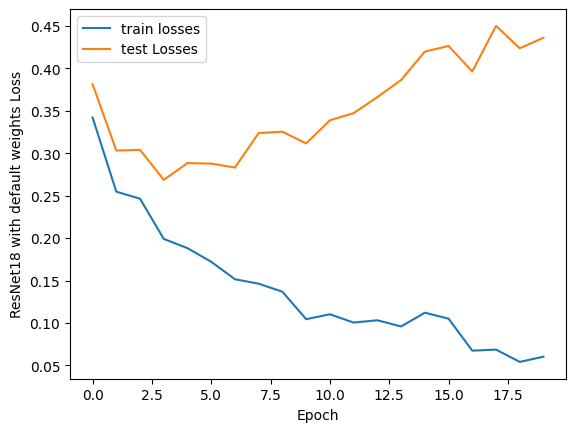

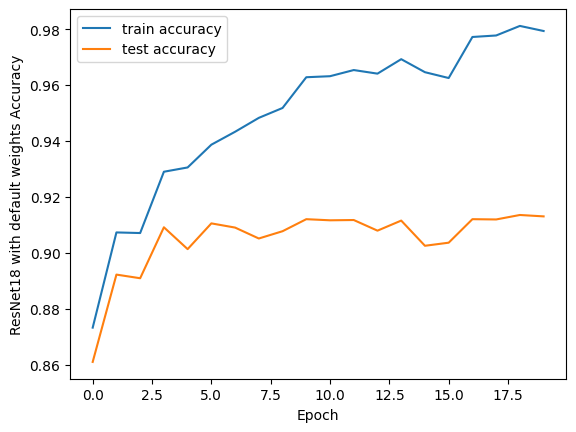

In [ ]:
# Plotting the training losses and accuracies for comparison
plt.plot(train_loss_default, label='train losses')
plt.plot(test_loss_default, label='test Losses')
plt.xlabel('Epoch')
plt.ylabel('ResNet18 with default weights Loss')
plt.legend()
plt.show()

plt.plot(train_acc_default, label='train accuracy')
plt.plot(test_acc_default, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('ResNet18 with default weights Accuracy')
plt.legend()
plt.show()

Approach 3: Freeze All But the Last Layer

In [ ]:
# Load ResNet18 with default weights
resnet18_freeze = models.resnet18(pretrained=True)

# Freeze all layers except the last one
for param in resnet18_freeze.parameters():
    param.requires_grad = False

# Modify the last layer for 10 classes
resnet18_freeze.fc = nn.Linear(resnet18_freeze.fc.in_features, 10)

resnet18_freeze_optimizer = optim.Adam(resnet18_freeze.parameters(), lr=1e-3)

resnet18_freeze.to(device)

# Example usage
train_loss_freeze, train_acc_freeze, test_loss_freeze, test_acc_freeze = train_loop(train_dataloader, test_dataloader, resnet18_freeze, loss_fn, resnet18_freeze_optimizer, 20)

Epoch 1:

loss: 2.157597  [   64/60000]
loss: 1.285522  [ 6464/60000]
loss: 0.946848  [12864/60000]
loss: 0.985000  [19264/60000]
loss: 1.028667  [25664/60000]
loss: 0.973918  [32064/60000]
loss: 0.848792  [38464/60000]
loss: 0.830256  [44864/60000]
loss: 1.071961  [51264/60000]
loss: 0.942880  [57664/60000]
Train Error: 
 Accuracy: 71.8%, Avg loss: 0.831421 

Test Error: 
 Accuracy: 70.5%, Avg loss: 0.861482 

Epoch 2:

loss: 0.869598  [   64/60000]
loss: 0.824988  [ 6464/60000]
loss: 0.809125  [12864/60000]
loss: 0.812777  [19264/60000]
loss: 0.850456  [25664/60000]
loss: 0.892312  [32064/60000]
loss: 0.801393  [38464/60000]
loss: 0.798149  [44864/60000]
loss: 1.053315  [51264/60000]
loss: 0.889526  [57664/60000]
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.789430 

Test Error: 
 Accuracy: 71.6%, Avg loss: 0.830521 

Epoch 3:

loss: 0.854709  [   64/60000]
loss: 0.770580  [ 6464/60000]
loss: 0.782680  [12864/60000]
loss: 0.784732  [19264/60000]
loss: 0.798685  [25664/60000]
loss: 0.86

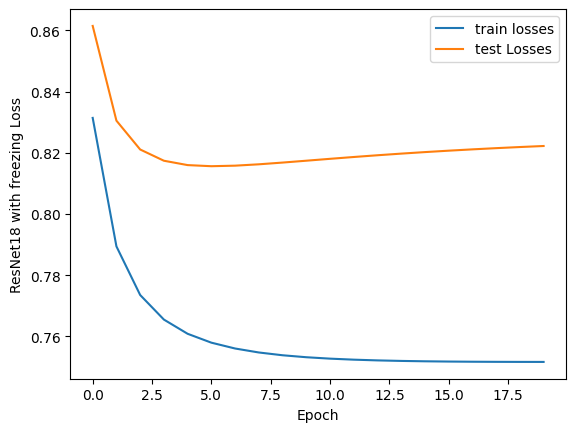

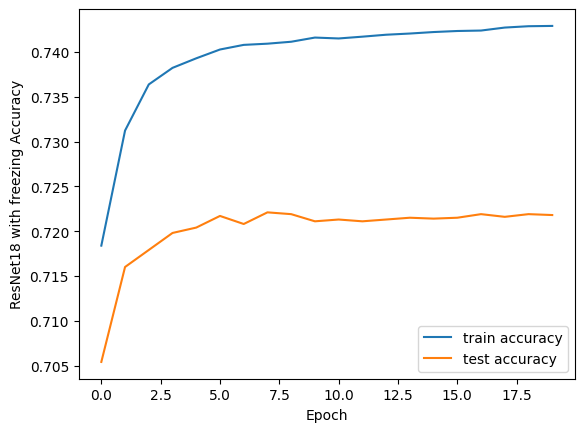

In [ ]:
# Plotting the training losses and accuracies for comparison
plt.plot(train_loss_freeze, label='train losses')
plt.plot(test_loss_freeze, label='test Losses')
plt.xlabel('Epoch')
plt.ylabel('ResNet18 with freezing Loss')
plt.legend()
plt.show()

plt.plot(train_acc_freeze, label='train accuracy')
plt.plot(test_acc_freeze, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('ResNet18 with freezing Accuracy')
plt.legend()
plt.show()

Commentary:

1. Random Weights (Approach 1):

The last fully connected layer is replaced with a new one with random weights.
The model starts with randomly initialized weights and learns the optimal parameters during training.
Training from scratch can take longer compared to using pretrained weights.

Results in gradual improvement in both training and test accuracy over epochs.


2. Default Pretrained Weights (Approach 2):

The last fully connected layer is replaced with a new one, and the model is initialized with weights pre-trained on ImageNet.
The model leverages knowledge learned from ImageNet and fine-tunes for the specific task (transfer learning).
Faster convergence and potentially better performance compared to training from random weights.

Results in better performance compared to training from random weights.


3. Freeze All But Last Layer (Approach 3):

All layers except the last one are frozen, meaning their weights are not updated during training.
This approach is essentially feature extraction. The pretrained layers act as fixed feature extractors, and only the last layer is trained for the specific task.
Faster training as only the last layer is updated, but it may not capture task-specific features as effectively.

There might be a decrease in test accuracy compared to the previous approaches, but overfitting is reduced.


The freezing of layers is a common strategy when dealing with limited data to prevent overfitting, especially when using pretrained models.
Fine-tuning a model with frozen convolutional layers is a compromise between using pretrained features and adapting to the specific task.
Overfitting is addressed by training a smaller number of parameters, mainly the weights of the final fully connected layer.